# LSTM

## LSTM Layer의 Forward propagation

# $$\mathbf{h_t} = \text{tanh}(\mathbf{x_tW_x + h_{t-1}W_h +b})$$

### **각 GATE의 연산**

# $\begin{array}{lcl}
\mathbf{f} & = & \sigma(\mathbf{x_tW_x^{(\mathbf{f})}}+\mathbf{h_{t-1}W_h^{(\mathbf{f})}} + \mathbf{b^{(\mathbf{f})}}) \\
\mathbf{\hat{c}} & = & \text{tanh}(\mathbf{x_tW_x^{(\mathbf{c})}}+\mathbf{h_{t-1}W_h^{(\mathbf{c})}} + \mathbf{b^{(\mathbf{c})}})\\
\mathbf{i} & = & \sigma(\mathbf{x_tW_x^{(\mathbf{i})}}+\mathbf{h_{t-1}W_h^{(\mathbf{i})}} + \mathbf{b^{(\mathbf{i})}}) \\
\mathbf{o} & = & \sigma(\mathbf{x_tW_x^{(\mathbf{o})}}+\mathbf{h_{t-1}W_h^{(\mathbf{o})}} + \mathbf{b^{(\mathbf{o})}}) \\
\end{array}$

# $\begin{array}{lcl}
\mathbf{c_t} & = & \mathbf{f \odot c_{t-1} + g \odot i}\\
\mathbf{h_t} & = & \mathbf{o} \odot \text{tanh}(\mathbf{c_t})\\
\end{array}$

In [1]:
# 아다마르 곱: 행렬의 대응되는 원소끼리 곱

---

### **각 식의 weight를 묶어 한 번에 계산**

<img src="lstm_affine1.png">

#### cf. Affine 연산

# $$A = \mathbf{x_tW_x + h_{t-1}W_h +b}$$

#### cf. LSTM 연산

<img src="lstm_affine2.png">

#### Slice 노드의 forward, backward

<img src="lstm_affine3.png">

# LSTM 구현

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        '''
        h_prev : 이전 시각의 hidden state
        c_prev : 이전 시각의 cell state
        '''
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        # Affine 변환 4개분을 한 번에 처리한 뒤 각각을 slice함
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        c = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        # 각각의 gate를 계산하고
        f = sigmoid(f)
        c = np.tanh(c)
        i = sigmoid(i)
        o = sigmoid(o)
        
        # c_next와 h_next를 계산
        c_next = f * c_prev + c * i
        h_next = o * np.tanh(c_next)
        
        # backward를 위해 저장
        self.cache = (x, h_prev, c_prev, i, f, c, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        '''
        dh_next와 dc_next는 상류로부터 내려오는 gradient
        '''
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, c, o, c_next = self.cache

        '''
        tanh_c_next : output gate과 곱하기 전의 c_t
                      tanh 연산노드의 local gradient를 구하기 위해서 계산함.
        dh_next : 위 그림에서 위로 분기한 h_t와 옆으로 분기한 h_t 각각에서 내려오는
                  gradient를 더한 것, * 연산노드로 backward 되는 값
        ds : c_(t-1)에서 c_t 사이의 +연산노드로 backward 되는 값
        dc_prev : c_(t-1)에서 c_t 사이의 * 연산노드 뒤로 backward 되는 값
        '''
        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        dc_prev = ds * f

        # 각 gate의 *연산 노드에 대한 미분
        df = ds * c_prev
        dc = ds * i
        di = ds * c
        do = dh_next * tanh_c_next
        
        # activation function(sigmoid) 미분. dc는 tanh 미분
        df *= f * (1 - f)
        dc *= (1 - c ** 2)
        di *= i * (1 - i)
        do *= o * (1 - o)

        # 각각의 gradient를 모두 묶어 dA로 만든 뒤
        # 한꺼번에 backward
        dA = np.hstack((df, dc, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0) # cf. b와 db는 code상에서 1 x 4H입니다. forward시 broadcasting되고 backward시 다시 원래크기로

        # 각 gradient를 인스턴스 변수에 저장
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        # 하류로 흘려보낼 gradient. embedding layer의 학습에 사용된다.
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

# Time LSTM Layer 구현
- T개의 LSTM 계층으로 구성된 LSTM Layer을 만듭니다.
- TimeRNN과 거의 유사하지만, weight의 column수가 4배가 됩니다.

In [8]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

# 2.LSTM Language Model(RNNLM)

RNN 대신 LSTM을 사용하여 Language Model을 구현합니다.

## RNNLM CODE

In [9]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel): # BaseModel 클래스는 모델을 좀 더 간결하게 작성하기 위한 뼈대가 되는 클래스입니다.
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs): # seq2seq 모델에서 문장 생성시 사용합니다.
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


## RNNLM Training & Evaluation

### Langube Model의 평가

# $$ \mathbf{preplexity} = e^L $$ 

Done
Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.54
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 2828.12
| 에폭 1 |  반복 41 / 1327 | 시간 8[s] | 퍼플렉서티 1224.74
| 에폭 1 |  반복 61 / 1327 | 시간 13[s] | 퍼플렉서티 967.78
| 에폭 1 |  반복 81 / 1327 | 시간 17[s] | 퍼플렉서티 780.34
| 에폭 1 |  반복 101 / 1327 | 시간 21[s] | 퍼플렉서티 648.01
| 에폭 1 |  반복 121 / 1327 | 시간 25[s] | 퍼플렉서티 627.96
| 에폭 1 |  반복 141 / 1327 | 시간 29[s] | 퍼플렉서티 597.41
| 에폭 1 |  반복 161 / 1327 | 시간 34[s] | 퍼플렉서티 556.53
| 에폭 1 |  반복 181 / 1327 | 시간 38[s] | 퍼플렉서티 589.11
| 에폭 1 |  반복 201 / 1327 | 시간 42[s] | 퍼플렉서티 502.37
| 에폭 1 |  반복 221 / 1327 | 시간 46[s] | 퍼플렉서티 484.95
| 에폭 1 |  반복 241 / 1327 | 시간 50[s] | 퍼플렉서티 440.05
| 에폭 1 |  반복 261 / 1327 | 시간 55[s] | 퍼플렉서티 456.36
| 에폭 1 |  반복 281 / 1327 | 시간 59[s] | 퍼플렉서티 434.89
| 에폭 1 |  반복 301 / 1327 | 시간 63[s] | 퍼플렉서티 385.32
| 에폭 1 |  반복 321 / 1327 | 시간 67[s] | 퍼플렉서티 347.97
| 에폭 1 |  반복 341 / 1327 | 시간 72[s] | 퍼플렉서티 399.71
| 에폭 1 |  반복 361 / 1327 | 시간 76[s] | 퍼플렉서티 399.86
| 에폭 1 |  반복 381 / 1327 | 시간 80[s] | 퍼플렉서티 33

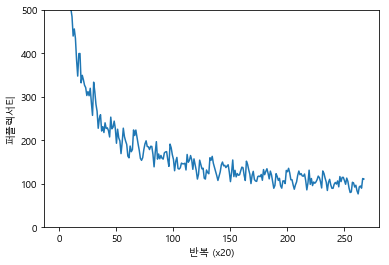

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  137.3193185856232


In [2]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()